In [1]:
import pandas as pd

import glob

from pathlib import Path
import csv

import glob

In [2]:
# Machine-learning specific imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
## API Imports 
import os
import requests
import json

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [5]:
## FMP Constants 
fmpbase_urlv3 = 'https://fmpcloud.io/api/v3/'
fmpbase_urlv4 = 'https://fmpcloud.io/api/v4/'
api_key = os.getenv("FMP_CLOUD_API_KEY")

start_date = '2022-01-01'
end_date = '2022-01-31'

## FMP Functions 
def get_FMP_historical_data(symbol, startDate=start_date, endDate=end_date, apiKey=api_key):
    url_hist_price = fmpbase_urlv3+'historical-price-full/'
    url_hist_query_with_date = url_hist_price+symbol+'?from='+startDate+'&to='+endDate+'&apikey='+apiKey
    resp_data = requests.get(url_hist_query_with_date)
    json_ = resp_data.json()
    data = json_['historical']
    df = pd.DataFrame(data)
    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.reindex(index=df.index[::-1]) ## Reverse the DataFrame 
    df.set_index('Date',inplace=True)
    df.drop(columns='label',inplace=True)
    return df

In [6]:
def get_data(symbol, n_days):
    path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
    data = load_obj(path)
    df = data[symbol]
    
    df_close = df[['close']]
    df_close = df_close.reset_index().rename(columns={"Date": "Close_Date"})
    
    features_df = df.reset_index().drop(columns=['close','adjClose'])
    
    new_close_df = df_close.iloc[n_days: , :].reset_index(drop=True)
    
    api_df = get_FMP_historical_data(symbol)
    new_data = api_df[['close']]
    new_data = new_data.reset_index().rename(columns={"Date": "Close_Date"})
    new_data = new_data.iloc[0:n_days]
    
    new_close_df = new_close_df.append(new_data, ignore_index=True)
    
    return features_df, new_close_df

In [7]:
def prepare_data(symbol,n_days,return_data=False):
    features_df, new_close_df = get_data(symbol,n_days)
    
    X = features_df.drop(columns='Date').values
    y = new_close_df['close'].values
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    if return_data == True:
        return X, y, features_df, new_close_df
    else:
        return X, y

In [33]:
symbol = 'GME'

X , y = get_data('GME',n_days=5)
X.head()

,Date,open,high,low,volume,unadjustedVolume,change,changePercent,vwap,changeOverTime,...,ShortVolumeNSDQ,ShortExemptVolumeNSDQ,TotalVolumeNSDQ,ShortVolumeNYSE,ShortExemptVolumeNYSE,TotalVolumeNYSE,bollinger_signal,dema_signal,adl_signal,rsi_signal
0,2016-02-02,26.629999,26.709999,25.590000,1840600.0,1840600.0,-0.71,-2.666,26.07333,-0.02666,...,117857.0,152.0,277309.0,11326.0,0.0,34626.0,0.692824,0.607545,-0.933333,0.180908
1,2016-02-03,26.110001,26.280001,24.750000,2223400.0,2223400.0,0.06,0.230,25.73333,0.00230,...,212359.0,14.0,523222.0,9575.0,0.0,26571.0,0.714956,0.657842,-0.933333,0.251669
2,2016-02-04,26.059999,27.190001,25.379999,2000200.0,2000200.0,0.95,3.645,26.52667,0.03645,...,156570.0,0.0,325811.0,17331.0,0.0,35015.0,0.591549,0.767042,-0.950000,0.666889
3,2016-02-05,27.010000,27.180000,26.430000,1545800.0,1545800.0,-0.18,-0.666,26.81333,-0.00666,...,115038.0,0.0,215572.0,6611.0,0.0,14960.0,0.617706,0.796823,-0.950000,0.532710
4,2016-02-08,26.549999,27.959999,26.500000,2944800.0,2944800.0,1.34,5.047,27.45000,0.05047,...,257398.0,30.0,496626.0,27972.0,0.0,66574.0,0.491616,0.857710,-0.933333,0.795060


In [34]:
for col in X.columns:
    print(col)

Date
open
high
low
volume
unadjustedVolume
change
changePercent
vwap
changeOverTime
QUANTITY_FAILS
ShortVolumeNSDQ
ShortExemptVolumeNSDQ
TotalVolumeNSDQ
ShortVolumeNYSE
ShortExemptVolumeNYSE
TotalVolumeNYSE
bollinger_signal
dema_signal
adl_signal
rsi_signal


In [10]:
y.head()

,Close_Date,close
0,2016-02-09,27.120001
1,2016-02-10,26.650000
2,2016-02-11,26.670000
3,2016-02-12,26.980000
4,2016-02-16,28.000000


In [21]:
## Takes one symbol and runs model data. 
## Call function for each individal symbol. No return data.  

def mean_squared_model(
    symbol,
    export_path,  ## Require export path to help avoiding re-writing models 
    n_days = 5, ## Default value 5, but should be tried with 1-30 
    model_count = 5, ## Number of times model runs before saving the best one. 
    validation_split_value=0.3,
    epochs_value=400,
    units1 = 8,
    units2 = 8,
    model_type = 'NN'
    ):
    
    
    export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string
    
    
#     path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
      
#     data = load_obj(path)
#     import_df = data[symbol]
#     df = import_df.copy()
#     #data_dict[key] = df        ## Not needed, use get_data() 
    
    
    X, y, = prepare_data(symbol,n_days)
    
    n_days_string = str(n_days) ## For exporting because can't concat 'int'
    
        
    # X = df.drop(columns={'close','adjClose'}).values
    # y = df['close'].values
    
    
    
    num_of_inputs = 20
    num_of_outputs= 1

    for i in range(model_count):
        model_summary = {}
        ## Create Neural Network 

        # Define the model - deep neural network with two layers
        nn = Sequential()

        # First hidden layer
        nn.add(Dense(units=units1, input_dim=num_of_inputs, activation="relu"))

        # Second hidden layer
        nn.add(Dense(units=units2, activation="relu"))

        # Output layer
        nn.add(Dense(units=num_of_outputs, activation="linear"))

        # Compile the model
        nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

        # Fit the model
        model = nn.fit(X, y, 
                          validation_split=validation_split_value, 
                          epochs=epochs_value, 
                          verbose=0)
            
        ## End of if/elif

        model_loss, model_accuracy = nn.evaluate(X, y, verbose=0)
        
        model_summary = {
            'model_accuracy':model_accuracy,
            'n_days':n_days,
            'validation_split_value':validation_split_value,
            'epochs_value':epochs_value,
                        }
        
        ## Save first model 
        if i == 0:
            model_accuracy_ = model_accuracy
            symbol_accuracy_dict[symbol] = {
                'model_accuracy':model_accuracy,
                'n_days':n_days
            }
            
            # Save model data
            nn_json = nn.to_json()
            file_path = Path(export_path_prefix+'_model_data.json')
            with open(file_path, "w") as json_file:
                json_file.write(nn_json)

            # Save weights
            file_path = (export_path_prefix+'_model_weights.h5')
            nn.save_weights(file_path)
            
            ## Save model summary 
            file_path = (export_path_prefix+'_model_summary.pkl')
            save_obj(model_summary,file_path)
            
        ## Rewrite saved model if accuracy better 
        else:
            if model_accuracy < model_accuracy_:
                ## Rewrite values 
                model_accuracy_ = model_accuracy
                symbol_accuracy_dict[symbol] = {
                    'model_accuracy':model_accuracy,
                    'n_days':n_days
                }
                
                # Rewrite saved files
                
                ## Save model data
                nn_json = nn.to_json()
                file_path = Path(export_path_prefix+'_model_data.json')
                with open(file_path, "w") as json_file:
                    json_file.write(nn_json)

                # Save weights
                file_path = (export_path_prefix+'_model_weights.h5')
                nn.save_weights(file_path)
                
                ## Save model summary 
                file_path = (export_path_prefix+'_model_summary.pkl')
                save_obj(model_summary,file_path)
    ## End of for loop 
    ## Return nothing 

In [12]:
## Create empty dicts for accuracy data - only really needed when 
## looping multiple symbols or different models. 
symbol_accuracy_dict = {}

symbol = 'GME'
n_days = 5

for i in range(1,11):
    mean_squared_model(symbol,export_path='../Model_Data/Date_Test_NN/',
                       n_days=i,
                       epochs_value=400)

In [14]:
symbol_accuracy_dict ## Rewrote dict with only one entry because same symbol 

{'GME': {'model_accuracy': 665.5789184570312, 'n_days': 10}}

In [15]:
# ## load model data 
# file_path = Path('../Model_Data/Date_Test_NN/'+symbol+'_NN_model_data.json')
# with open(file_path, "r") as json_file:
#     model_json = json_file.read()
# loaded_model = model_from_json(model_json)

# # load weights into new model
# file_path = Path('../Model_Data/Date_Test_NN/'+symbol+'_NN_model_weights.h5')
# loaded_model.load_weights(file_path)

# # Load model summary
# file_path = Path('../Model_Data/Date_Test_NN/'+symbol+'_model_summary.pkl')
# model_summary = load_obj(file_path)

# X , y, features, close_df = prepare_data(symbol,n_days,return_data=True)


# close_df["predicted"] = loaded_model.predict(X)

In [16]:
export_path='../Model_Data/Date_Test_NN/'
model_type = 'NN'

model_summary_list = [] 

for i in range(1,11):
    # Load model summary
    n_days_string = str(i)
    file_path = Path('_model_summary.pkl')
    model_summary = load_obj(file_path)
    
    model_summary_list.append(model_summary)

In [18]:
#model_summary_list

<AxesSubplot:xlabel='Close_Date'>

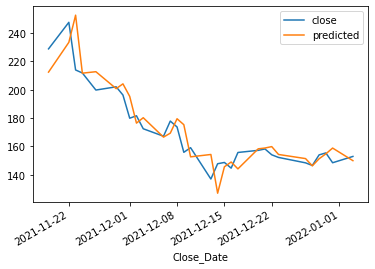

In [31]:
n_days = 1

n_days_string = str(n_days)

file_path = Path(export_path+symbol+'_'+model_type+'_'+n_days_string+'_model_data.json')
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# load weights into new model
file_path = Path(export_path+symbol+'_'+model_type+'_'+n_days_string+'_model_weights.h5')
loaded_model.load_weights(file_path)

X , y, features, close_df = prepare_data(symbol,n_days,return_data=True)


close_df["predicted"] = loaded_model.predict(X)
close_df.set_index('Close_Date',inplace=True)
close_df[['close','predicted']].tail(30).plot(use_index=True)